In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [91]:
!if [[ -z "${KAGGLE_KERNEL_RUN_TYPE}"]]; then echo "kaggle"; else echo "local"; fi

zsh:1: parse error near `;'


In [96]:
%%bash
(
if [[ -z "${KAGGLE_KERNEL_RUN_TYPE}" ]]; then
    echo "local"
else
    echo "kaggle";
    # git clone 
fi
)

local


In [69]:
from typing import Callable, Optional, Any, Tuple


class CustomCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root: str, train: bool = True, transform: Callable[..., Any] | None = None, target_transform: Callable[..., Any] | None = None, download: bool = False) -> None:
        super().__init__(root, train, transform, target_transform, download)
        all_a, all_b = [], []
        for a, b in zip(self.data, self.targets):
            remove_class_name = "frog"
            remove_index = self.classes.index(remove_class_name)
            if b != remove_index:
                all_a.append(a)
                if b > remove_index:
                    all_b.append(b-1)
                else:
                    all_b.append(b)
        self.data = all_a
        self.targets = all_b
        self.classes.remove(remove_class_name)
        

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        img = np.array(img)

        if self.transform is not None:
            img = self.transform(image=img)['image']

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [70]:
from multiprocessing import cpu_count

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

transform_train = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.GaussNoise(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.2),
    A.Normalize(mean=mean, std=std),
    A.pytorch.ToTensorV2(),
])

transform_test = A.Compose([
        A.Resize(32, 32),
        A.Normalize(mean=mean, std=std),
        A.pytorch.ToTensorV2(),
    ])

train_dataset = CustomCIFAR10('data', train=True, download=True, transform=transform_train)
test_dataset = CustomCIFAR10('data', train=False, download=True, transform=transform_test)


batch_size = 64
num_workers = cpu_count() - 2
shuffle = True
drop_last = True
pin_memory = True if device.type == 'cuda' else False

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)


Files already downloaded and verified
Files already downloaded and verified


In [71]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

In [72]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
from torch import nn

for p in model.parameters():
    p.requires_grad = False

head = nn.Sequential(
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 250),
    nn.BatchNorm1d(250),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(250, 10)
)

model.fc = head

In [74]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model/state-ResNet-optimizer-Adam-loss-CrossEntropyLoss.pth exist


[27s] Epoch 57 loss : 2.24820177 acc: 25.48 val: 2.22687338 acc: 28.19%


[33s] Epoch 58 loss : 2.24771082 acc: 23.82 val: 2.22190168 acc: 25.42%


[34s] Epoch 59 loss : 2.24654090 acc: 21.34 val: 2.22159092 acc: 23.17%


Stopping Saving


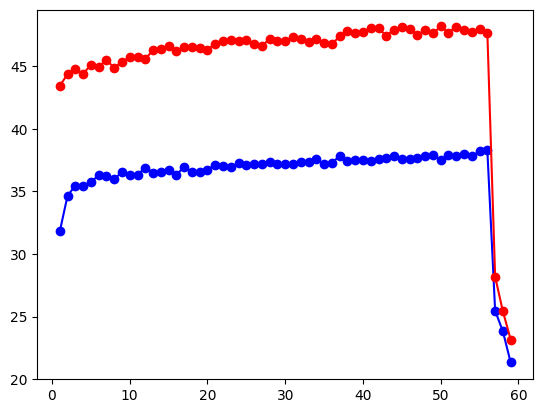

In [87]:
from train import train
from easydict import EasyDict

datasets = EasyDict({
    "train": train_dataset,
    "val": test_dataset,
    "test": test_dataset,
})
data_loaders = EasyDict({
    "train": train_loader,
    "val": test_loader,
    "test": test_loader,
})

state = train(
    net=model,
    criterion=criterion,
    optimizer=optimizer,
    dataset=datasets,
    data_loader=data_loaders,
    device=device,
    epochs=200,
)


In [77]:
a, b = next(iter(data_loaders.train))

In [78]:
l = model(a.to(device))

In [82]:
l.shape

torch.Size([64, 10])

In [85]:
from torch.functional import F
F.softmax(l, dim=0)

tensor([[5.6267e-06, 4.2874e-10, 3.0328e-15, 2.6700e-18, 1.5193e-18, 1.5028e-18,
         2.5762e-21, 1.2889e-01, 7.1350e-03, 3.2336e-15],
        [1.0605e-05, 2.1821e-18, 3.2736e-08, 1.8741e-06, 1.5440e-09, 3.1704e-10,
         2.9233e-12, 1.2376e-05, 4.3732e-11, 4.6267e-04],
        [3.0671e-11, 3.0631e-22, 6.9922e-02, 1.4233e-10, 6.0041e-05, 4.0842e-08,
         3.5715e-08, 1.2968e-16, 3.2758e-14, 2.0328e-11],
        [2.9580e-04, 2.4430e-16, 2.9255e-09, 1.4900e-05, 7.2290e-13, 1.2992e-10,
         3.1405e-16, 1.0814e-05, 3.7551e-14, 5.1482e-11],
        [5.6135e-04, 2.0974e-15, 4.9737e-12, 7.4959e-14, 1.8091e-08, 5.4890e-17,
         2.2380e-15, 1.4145e-01, 5.5046e-08, 7.5654e-08],
        [1.3301e-11, 3.4366e-10, 1.7942e-12, 4.4320e-11, 8.9354e-19, 4.3932e-21,
         1.6013e-12, 1.8034e-15, 9.3712e-01, 2.0231e-17],
        [1.3758e-11, 1.5601e-15, 1.7604e-13, 1.2427e-05, 2.5137e-18, 5.0987e-06,
         9.9942e-18, 3.7349e-08, 1.0594e-05, 1.0408e-13],
        [2.0041e-08, 7.5445

In [86]:
F.softmax(l, dim=1)

tensor([[3.0108e-05, 2.6125e-02, 1.8509e-14, 6.1149e-17, 3.0056e-18, 2.0504e-15,
         1.0968e-17, 8.9591e-01, 7.7935e-02, 3.0775e-27],
        [3.0453e-01, 7.1354e-07, 1.0721e-03, 2.3033e-01, 1.6391e-05, 2.3213e-03,
         6.6789e-05, 4.6166e-01, 2.5635e-06, 2.3631e-12],
        [3.8431e-10, 4.3707e-14, 9.9924e-01, 7.6331e-09, 2.7814e-04, 1.3048e-04,
         3.5605e-04, 2.1107e-15, 8.3788e-13, 4.5304e-23],
        [7.9163e-01, 7.4452e-06, 8.9294e-06, 1.7067e-01, 7.1526e-10, 8.8653e-05,
         6.6871e-10, 3.7594e-02, 2.0514e-10, 2.4506e-20],
        [3.0457e-03, 1.2959e-07, 3.0778e-11, 1.7407e-12, 3.6289e-08, 7.5937e-14,
         9.6613e-12, 9.9695e-01, 6.0967e-07, 7.3010e-20],
        [6.9391e-12, 2.0416e-03, 1.0675e-12, 9.8962e-11, 1.7234e-19, 5.8438e-19,
         6.6467e-10, 1.2221e-15, 9.9796e-01, 1.8772e-30],
        [1.0007e-08, 1.2921e-05, 1.4602e-10, 3.8685e-02, 6.7591e-16, 9.4554e-01,
         5.7834e-12, 3.5286e-05, 1.5729e-02, 1.3465e-23],
        [1.9838e-02, 8.5045